In [2]:

# 0 ─ SETUP & LIBRARIES

!pip install -q tensorflow
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
print("TensorFlow:", tf.__version__)


TensorFlow: 2.18.0


In [3]:

# 1 ─ MOUNT GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

# 2 ─ LOAD IMAGE PATHS + AGE LABELS  (update folder if needed)

folder = "/content/drive/MyDrive/UTKFace"

rows = []
for f in os.listdir(folder):
    try:
        age = int(f.split('_')[0])
        if 0 < age <= 100:
            rows.append([os.path.join(folder, f), age])
    except:
        pass

df = pd.DataFrame(rows, columns=['image_path', 'age'])
print("Total images:", len(df))
df.head()


Total images: 12588


,image_path,age
0,/content/drive/MyDrive/UTKFace/32_0_0_20170116...,32
1,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31
2,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31
3,/content/drive/MyDrive/UTKFace/31_1_3_20170119...,31
4,/content/drive/MyDrive/UTKFace/31_1_3_20170117...,31


In [5]:

# 3 ─ BIN AGES INTO 8 CLASSES

bins   = [0,4,12,20,32,43,55,70,100]
labels = list(range(len(bins)-1))
df['age_bin'] = pd.cut(df.age, bins=bins, labels=labels).astype(int)
df.head()


,image_path,age,age_bin
0,/content/drive/MyDrive/UTKFace/32_0_0_20170116...,32,3
1,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31,3
2,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31,3
3,/content/drive/MyDrive/UTKFace/31_1_3_20170119...,31,3
4,/content/drive/MyDrive/UTKFace/31_1_3_20170117...,31,3


In [6]:

# 4 ─ TRAIN / VALIDATION SPLIT

train_df, val_df = train_test_split(df, test_size=0.2,
                                    stratify=df.age_bin,
                                    random_state=42)
print(f"Train: {len(train_df)},  Val: {len(val_df)}")


Train: 10070,  Val: 2518


In [7]:

# 5 ─ IMAGE DATA GENERATORS

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32


train_df['age_bin'] = train_df['age_bin'].astype(str)
val_df['age_bin']   = val_df['age_bin'].astype(str)

datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='age_bin',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='age_bin',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10070 validated image filenames belonging to 6 classes.
Found 2518 validated image filenames belonging to 6 classes.


In [11]:


# 6 ─ BUILD MODEL

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks

base = ResNet50(include_top=False,
                input_shape=(224, 224, 3),
                pooling='avg',
                weights='imagenet')

for layer in base.layers[:-10]:
    layer.trainable = False


NUM_CLASSES = len(train_gen.class_indices)
print("NUM_CLASSES for model:", NUM_CLASSES)

x = layers.BatchNormalization()(base.output)
x = layers.Dropout(0.5)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(base.input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


NUM_CLASSES for model: 6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,608,198 (90.06 MB)

 Trainable params: 3,432,966 (13.10 MB)

 Non-trainable params: 20,175,232 (76.96 MB)

In [12]:


# 7 ─ TRAIN  (updated & clean)

from tensorflow.keras import callbacks

ckpt = callbacks.ModelCheckpoint(
        filepath='best_age_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1)

early = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1)

history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=[ckpt, early])



Epoch 1/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6869 - loss: 1.0436
Epoch 1: val_accuracy improved from -inf to 0.69976, saving model to best_age_model.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 2705s 9s/step - accuracy: 0.6872 - loss: 1.0428 - val_accuracy: 0.6998 - val_loss: 0.9717
Epoch 2/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8125 - loss: 0.6026
Epoch 2: val_accuracy did not improve from 0.69976
315/315 ━━━━━━━━━━━━━━━━━━━━ 2481s 8s/step - accuracy: 0.8125 - loss: 0.6026 - val_accuracy: 0.1128 - val_loss: 2.3847
Epoch 3/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8181 - loss: 0.5691
Epoch 3: val_accuracy did not improve from 0.69976
315/315 ━━━━━━━━━━━━━━━━━━━━ 2481s 8s/step - accuracy: 0.8181 - loss: 0.5691 - val_accuracy: 0.1465 - val_loss: 3.0641
Epoch 4/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8289 - loss: 0.5492
Epoch 4: val_accuracy did not improve from 0.69976
315/315 ━━━━━━━━━━━━━━━━━━━━ 2548s 8s/step - accuracy: 0.8288 - loss: 0.5492 - val_accuracy: 0.1521 - val_loss: 3.0378
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000       323
           1      0.000     0.000     0.000        70
           2      0.000     0.000     0.000       295
           3      0.700     1.000     0.823      1762
           4      0.000     0.000     0.000        66
           7      0.000     0.000     0.000         2

    accuracy                          0.700      2518
   macro avg      0.117     0.167     0.137      2518
weighted avg      0.490     0.700     0.576      2518



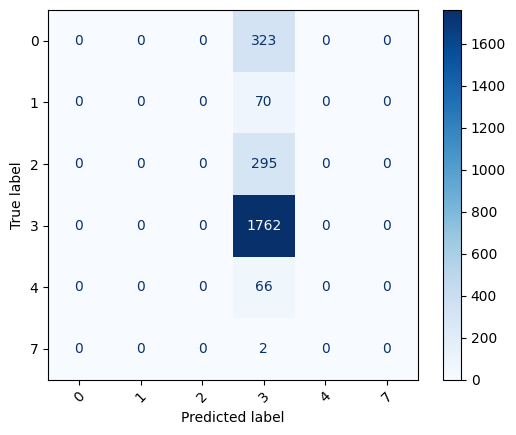

In [14]:

# 8 ─ EVALUATION  (fixed for label‑type mismatch)

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Reset generator & predict
val_gen.reset()
y_pred_idx = model.predict(val_gen, verbose=0).argmax(axis=1)

# 2) Build mapping index → label‑string  (e.g. '0', '1', ...)
idx_to_label = {v: k for k, v in val_gen.class_indices.items()}
y_pred = np.array([idx_to_label[i] for i in y_pred_idx])
y_true = val_df.age_bin.values

# 3) Classification report
print(classification_report(y_true, y_pred, digits=3))

# 4) Confusion matrix
class_labels = list(val_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
ConfusionMatrixDisplay(cm, display_labels=class_labels)\
    .plot(xticks_rotation=45, cmap='Blues')
plt.show()


In [15]:

# 9 ─ SAVE FINAL MODEL

model.save('saved_model.h5')
print("Model saved as saved_model.h5")


Model saved as saved_model.h5


In [16]:
!cp saved_model.h5 /content/drive/MyDrive/
